A common challenge in working with operational or CRM-style data is that you often find yourself dealing with user-entered free text. A recurrent example comes when users fill out forms that ask for their job title and employer. This data might seem secondary, but for any organization trying to understand, segment, or personalize communication with its users, it's incredibly valuable.

Of course, user-entered data is messy. One person types "nurse," another "ER Nurse," another "RN," and yet another "home health nursing." If you want to understand the composition of your user base, or build automated systems that adapt to it, you need to normalize that chaos into a finite and meaningful taxonomy. You wouldn't want a dashboard full of job titles in [SpongeBob casing](https://knowyourmeme.com/memes/mocking-spongebob), but realistically, you have to work with whatever comes through the form.

A data-forward organization might use this information for all kinds of purposes: tailoring outreach, prioritizing leads, enriching analytics, or even customizing onboarding flows. But none of that works without being clean, consistent, and structured.

With language models, we can do better. We don't need to predefine normalization rules or manually review each row. And we don't even need much prior knowledge about our users to start.

But before we jump straight to the AI, let's define our approach:

1. To normalize free-form text, there must be a finite set of target categories.
2. If we know nothing about users in advance, we need a reliable way to discover or define those categories.
3. We're decidedly not using a chatbot, and we're not relying on external APIs.
4. This isn't a generative task; it's about semantic understanding.

Let's start at the top. There are an infinite number of values a user could enter for their job, and we want to reduce that to a finite set. So where do we get that set?

The [Occupational Information Network](https://en.wikipedia.org/wiki/Occupational_Information_Network) (O\*NET) maintains exactly such a resource. Developed under the sponsorship of the Departoment of Labor, O\*NET offers rich [datasets](https://www.onetcenter.org/database.html#individual-files) that describe skills, knowlege, tasks, and job titles. We're interested in the [Alternate Titles](https://www.onetcenter.org/dictionary/29.3/excel/alternate_titles.html) file, which maps occupation titles to alternate "lay" job titles. There's a good chance many of our users enter these alternate titles, so we'll want to include them.

The file includes columns of Department of Labor and Census identifiers, but we only need the few that focus on title. Let's download it and take a look at a few examples:

In [1]:
import numpy as np
import pandas as pd

onet_df = pd.read_excel(
    "https://www.onetcenter.org/dl_files/database/db_29_3_excel/Alternate%20Titles.xlsx",
    usecols=['Title', 'Alternate Title', 'Short Title'],
).fillna("")

onet_df.sample(n=5, random_state=101)  # seed for reproducibility

,Title,Alternate Title,Short Title
25268,Cargo and Freight Agents,Shipping Agent,
30407,"Helpers, Construction Trades, All Other",Maintenance Construction Helper,
6045,Bioengineers and Biomedical Engineers,Biomedical Engineering Intern,
18684,Occupational Therapy Aides,Rehabilitation Therapy Aide (Rehab Therapy Aide),Rehab Therapy Aide
24086,Billing and Posting Clerks,Statement Services Representative (Statement S...,Statement Services Rep


So O\*NET tells us that **Cargo and Freight Agents** might also go by a **Shipping Agent** as an `Alternate Title` and that **Occupational Therapy Aides** might also go by a **Rehab Therapy Aide** as a `Short Title`.

We also see that there can be many rows of different `Alternate Title` and `Short Title` for the same `Title`:

In [2]:
onet_df[onet_df["Title"] == "Software Developers"]

,Title,Alternate Title,Short Title
4931,Software Developers,.NET Developer,
4932,Software Developers,Android Developer,
4933,Software Developers,AngularJS Developer,
4934,Software Developers,Apache Hadoop Developer,
4935,Software Developers,Application Architect,
...,...,...,...
5061,Software Developers,User Interface Designer,
5062,Software Developers,Video Game Engineer,
5063,Software Developers,Wide Area Network Engineer (WAN Engineer),WAN Engineer
5064,Software Developers,Windows Software Engineer,


There is one thing we do know ahead of time about our users: not all of them will be employed. The O\*NET data set doesn't provide a job title for not working, so let's add our own:

In [3]:
additions = pd.DataFrame(
    [
        {"Title": "Unemployed", "Alternate Title": "Not Employed"},
        {"Title": "Unemployed", "Alternate Title": "None"},
        {"Title": "Unemployed", "Alternate Title": "N/A"},
        {"Title": "Unemployed", "Alternate Title": "No Employment"},
        {"Title": "Unemployed", "Alternate Title": "Not Working"},
        {"Title": "Retired", "Alternate Title": "Retiree"},
    ]
)
onet_df = pd.concat([onet_df, additions], ignore_index=True).fillna("")
onet_df[(onet_df["Title"] == "Unemployed") | (onet_df["Title"] == "Retired")]

,Title,Alternate Title,Short Title
56560,Unemployed,Not Employed,
56561,Unemployed,None,
56562,Unemployed,N/A,
56563,Unemployed,No Employment,
56564,Unemployed,Not Working,
56565,Retired,Retiree,


Now let's merge these fields together. Since we'll be leveraging a language model, we can take the liberties of language here; we don't need clean many-to-many relationships. Just combine `Title`, `Alternate Title`, and when available, `Short Title` into one `Long Title` field with ` "aka" ` inline:

In [4]:
mask = onet_df["Short Title"].eq("")

onet_df["Long Title"] = np.where(
    mask,
    onet_df["Title"] + " aka " + onet_df["Alternate Title"],
    onet_df["Title"] + " aka " + onet_df["Alternate Title"] + " aka " + onet_df["Short Title"],
)

onet_df[onet_df["Title"] == "Software Developers"]

,Title,Alternate Title,Short Title,Long Title
4931,Software Developers,.NET Developer,,Software Developers aka .NET Developer
4932,Software Developers,Android Developer,,Software Developers aka Android Developer
4933,Software Developers,AngularJS Developer,,Software Developers aka AngularJS Developer
4934,Software Developers,Apache Hadoop Developer,,Software Developers aka Apache Hadoop Developer
4935,Software Developers,Application Architect,,Software Developers aka Application Architect
...,...,...,...,...
5061,Software Developers,User Interface Designer,,Software Developers aka User Interface Designer
5062,Software Developers,Video Game Engineer,,Software Developers aka Video Game Engineer
5063,Software Developers,Wide Area Network Engineer (WAN Engineer),WAN Engineer,Software Developers aka Wide Area Network Engi...
5064,Software Developers,Windows Software Engineer,,Software Developers aka Windows Software Engineer


Great. We've satisfied parts one and two of our approach. We have a finite set of job titles, and we have a good understanding that the set is large but not exhaustive, and it combines multiple values for a job title. Let's start modeling language.

[JobBERT-v2](https://huggingface.co/TechWolf/JobBERT-v2) is a [sentence-transformers](https://www.sbert.net/) model fine tuned from [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) specifically for job title matching and similarity. Hey that's convenient!

We can't use `JobBERT` out of the box, we'll need to incorporate our O\*NET dataset. Let's pull it down and start building out our implementation of the model. To do this we're going to leverage [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) against our `Long Title` values. If you're unfamiliar with langage model embeddings, Simon Willison has a [fantastic overview](https://simonwillison.net/2023/Oct/23/embeddings/) that you should go read now. But the gist of it is: embeddings are how language models numerically encode meaning from language into a large vector. This is suprisingly powerful, and yields operations like:

`emb('king') - emb('man') + emb('woman')` which returns a vector that is mathmatically *very close* to `emb('queen')`.

We're going to use this "closeness" between vectors to reduce infinite free-form data to our finite `Long Title` data and then map it back to `Title`. The first thing to do is quite simple: calculate `JobBERT` embeddings on all of the values in our `Long Title` column:

In [14]:
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")

model = SentenceTransformer("TechWolf/JobBERT-v2")

onet_df["embedding"] = list(
    model.encode(
        onet_df["Long Title"].tolist(),
        normalize_embeddings=True,
        convert_to_numpy=True,
        show_progress_bar=False,
    )
)

onet_df[["Long Title", "embedding"]].sample(n=5, random_state=101)

,Long Title,embedding
25268,Cargo and Freight Agents aka Shipping Agent,"[-0.034480397, -0.01120864, -0.005822623, -0.0..."
30408,"Helpers, Construction Trades, All Other aka Me...","[-0.07022176, -0.020068161, 0.0111531215, -0.0..."
6045,Bioengineers and Biomedical Engineers aka Biom...,"[-0.030613927, -0.059320696, -0.01718829, -0.0..."
18684,Occupational Therapy Aides aka Rehabilitation ...,"[-0.014956265, -0.038792193, -0.00349255, 0.00..."
24086,Billing and Posting Clerks aka Statement Servi...,"[0.020981414, -0.033710796, 0.03225505, -0.011..."


As a reader, the `embedding` column is an indecipherable array of floats, but now we can do some cool things. Here are three rows from our data:

In [6]:
slice = onet_df[
    (onet_df["Long Title"] == "Software Developers aka Video Game Engineer") |
    (onet_df["Long Title"] == "Database Architects aka Information Architect") |
    (onet_df["Long Title"] == "Cargo and Freight Agents aka Shipping Agent")
]
slice[["Long Title", "embedding"]]

,Long Title,embedding
4806,Database Architects aka Information Architect,"[0.020110216, 0.06301323, -0.029263753, -0.022..."
5062,Software Developers aka Video Game Engineer,"[0.041696787, 0.024444718, -0.053837907, 0.031..."
25268,Cargo and Freight Agents aka Shipping Agent,"[-0.034480397, -0.01120864, -0.005822623, -0.0..."


In a vector space, you can evaluate how similar two vectors are by taking their [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Since we normalized our vectors when we embedded them, the denominator in the cosine function becomes `1` so we can do this even more efficiently with just a [dot product](https://en.wikipedia.org/wiki/Dot_product):

In [7]:
database_architect = slice.iloc[0]["embedding"]
software_developer = slice.iloc[1]["embedding"]
cargo_and_freight_agent = slice.iloc[2]["embedding"]

print(f"Software Developer vs Data Architect: {software_developer @ database_architect}")
print(f"Software Developer vs Cargo Agent: {software_developer @ cargo_and_freight_agent}")

Software Developer vs Data Architect: 0.2380954772233963
Software Developer vs Cargo Agent: 0.08600345253944397


Those numbers look perfectly reasonable: a modest overlap (≈ 0.24) between two tech roles and an almost-orthogonal relationship (≈ 0.09) to the Cargo Agent job.

Great. So now we have a mathematical way to compare the language of two job titles. And we're not touching chatbots or 3rd party APIs at inferrence. The DataFrame is a self-contained model for semantically matching across the O\*NET dataset. We've fully satisfied our approach!

Now to apply it to our problem. Instead of evaluating O\*NET data against itself, we can use our embeddings to evaluate *any* free-form job title text a user might submit.

Let's go get some real data to try it out! Since I work in political tech, I like to reach for campaign donor data.

Our friends over at ProPublica [publish itemized ActBlue receipts by state](https://projects.propublica.org/itemizer/committee/C00401224/2024/filings/1791562/downloads). Because ActBlue is a conduit committee, these files include every transaction of any amount. That's a lot of transactions! Let's grab all of the ActBlue transactions from Texas for June 2024.

In [8]:
dtypes = {
    "flag_orgind": "string",
    "first_name": "string",
    "city": "string",
    "zip": "string",
    "amount": "float64",
    "occupation": "string",
}

abtx_df = pd.read_csv(
    "https://pp-projects-static.s3.amazonaws.com/itemizer/sa_1791562_tx.csv",
    usecols=dtypes.keys(),
    dtype=dtypes,
)
abtx_df = abtx_df[abtx_df["flag_orgind"] == "IND"]
abtx_df.drop(columns=["flag_orgind"], inplace=True)
abtx_df.dropna(inplace=True)

employed = lambda df: df["occupation"].ne("NOT EMPLOYED")
get_sample = lambda seed: abtx_df.loc[employed(abtx_df)].sample(n=10, random_state=seed)

get_sample(30330)  # seed for reproducibility

,first_name,city,zip,amount,occupation
139133,PAT,NORTH RICHLAND HIL,76180,9.0,RETIRED
4248,HARRY,HOUSTON,77019,125.0,LAWYER
221073,THAO,HOUSTON,77083,2.5,HISTOLOGY TECHNICIAN
201669,PHILIP,SAN ANTONIO,78240,3.0,MANAGER
256487,MARIA,HOLLAND,76534,1.0,HEALTHCARE ADMINISTRATOR
6330,ELLEN,BELLAIRE,77401,100.0,ARBITRATOR
125976,MICHELLE,FORT WORTH,76133,10.0,SERVER
13659,ROSE,HOUSTON,77024,75.0,NURSING
138213,PETER,HOUSTON,77019,9.0,DATABASE ANALYST
62939,ERIN,FRISCO,75035,25.0,NONPROFIT


That `occupation` field came from donors and doesn't perfectly match our modeled job titles. But we don't need it to! Let's use our model to calculate embeddings on these new values:

In [9]:
abtx_df["embedding"] = list(
    model.encode(
        abtx_df["occupation"].tolist(),
        normalize_embeddings=True,
        convert_to_numpy=True,
        show_progress_bar=False,
    )
)

get_sample(30330)

,first_name,city,zip,amount,occupation,embedding
139133,PAT,NORTH RICHLAND HIL,76180,9.0,RETIRED,"[-0.022304475, 0.08798518, 0.008374137, 0.0150..."
4248,HARRY,HOUSTON,77019,125.0,LAWYER,"[0.0123939905, 0.06054912, 0.0046267705, -0.03..."
221073,THAO,HOUSTON,77083,2.5,HISTOLOGY TECHNICIAN,"[0.027493875, -0.079993084, 0.013278877, -0.00..."
201669,PHILIP,SAN ANTONIO,78240,3.0,MANAGER,"[0.09953636, 0.07623968, 0.020005615, 0.001361..."
256487,MARIA,HOLLAND,76534,1.0,HEALTHCARE ADMINISTRATOR,"[0.036386397, 0.06352263, -0.0023324555, -0.02..."
6330,ELLEN,BELLAIRE,77401,100.0,ARBITRATOR,"[0.05744064, 0.03044543, -0.011071598, 0.01120..."
125976,MICHELLE,FORT WORTH,76133,10.0,SERVER,"[0.0222358, 0.025343752, -0.027377797, -0.0031..."
13659,ROSE,HOUSTON,77024,75.0,NURSING,"[0.008113306, 0.03859657, -0.014793488, -0.064..."
138213,PETER,HOUSTON,77019,9.0,DATABASE ANALYST,"[0.042439297, 0.08193651, -0.027909847, 0.0143..."
62939,ERIN,FRISCO,75035,25.0,NONPROFIT,"[-0.052989695, 0.19739158, 0.007059781, 0.0288..."


So now we have two sets of embeddings: we have our O\*NET embeddings and we have our ActBlue donor embeddings. Just as before, we can calculate similaries between them. But unlike before, we need to calculate _a lot_. In order to find the best match we need to compare every O\*NET embedding vector with every ActBlue embedding vector. That's a lot of comparisons. The good news, this is what GPUs are good at, and a free-tier GPU in Google Colab can kick this out fast.

We convert our O\*NET `embedding` column into a (n × d) tensor, where `n` is the number of rows and `d` is the vector length. Similarly, we convert the ActBlue `embedding` column into a (m × d) tensor where `m` is the number of ActBlue rows.

When pushing this to a GPU, it's a little more art than science. We batch it, and picking an optimal batch size can take some trial and error. For every batch, we'll calculate the dot product, and return the indices of the best similarities.

From there, we can map all the way back to our original O\*NET `Title` column, as our normalized output:

In [10]:
import torch

device = "cuda"  # requires an NVIDIA GPU + CUDA
onet_t = torch.tensor(np.stack(onet_df.embedding), device=device)  # (n × d)
abtx_t = torch.tensor(np.stack(abtx_df.embedding), device=device)  # (m × d)

batch = 4096  # tune to fit GPU RAM
best = []

with torch.no_grad():
    for s in range(0, abtx_t.size(0), batch):
        sims = abtx_t[s:s+batch] @ onet_t.T  # (batch × n)
        best.append(sims.argmax(dim=1).cpu())

idx = torch.cat(best).numpy()

abtx_df["Normalized Occupation"] = onet_df.Title.iloc[idx].to_numpy()

get_sample(30330)[["first_name", "occupation", "Normalized Occupation"]]

,first_name,occupation,Normalized Occupation
139133,PAT,RETIRED,Retired
4248,HARRY,LAWYER,Lawyers
221073,THAO,HISTOLOGY TECHNICIAN,Histology Technicians
201669,PHILIP,MANAGER,"Managers, All Other"
256487,MARIA,HEALTHCARE ADMINISTRATOR,Medical and Health Services Managers
6330,ELLEN,ARBITRATOR,"Arbitrators, Mediators, and Conciliators"
125976,MICHELLE,SERVER,"Food Servers, Nonrestaurant"
13659,ROSE,NURSING,Registered Nurses
138213,PETER,DATABASE ANALYST,Database Administrators
62939,ERIN,NONPROFIT,Fundraisers


A way to visualized this is with [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). PCA computes new orthogonal axes called principal components that capture the most variation in the data. These directions are combinations of the original dimensions, chosen to reveal the biggest patterns and differences. By projecting each vector onto the first two principal components, we can plot everything in two dimensions while keeping as much of the original structure as possible:

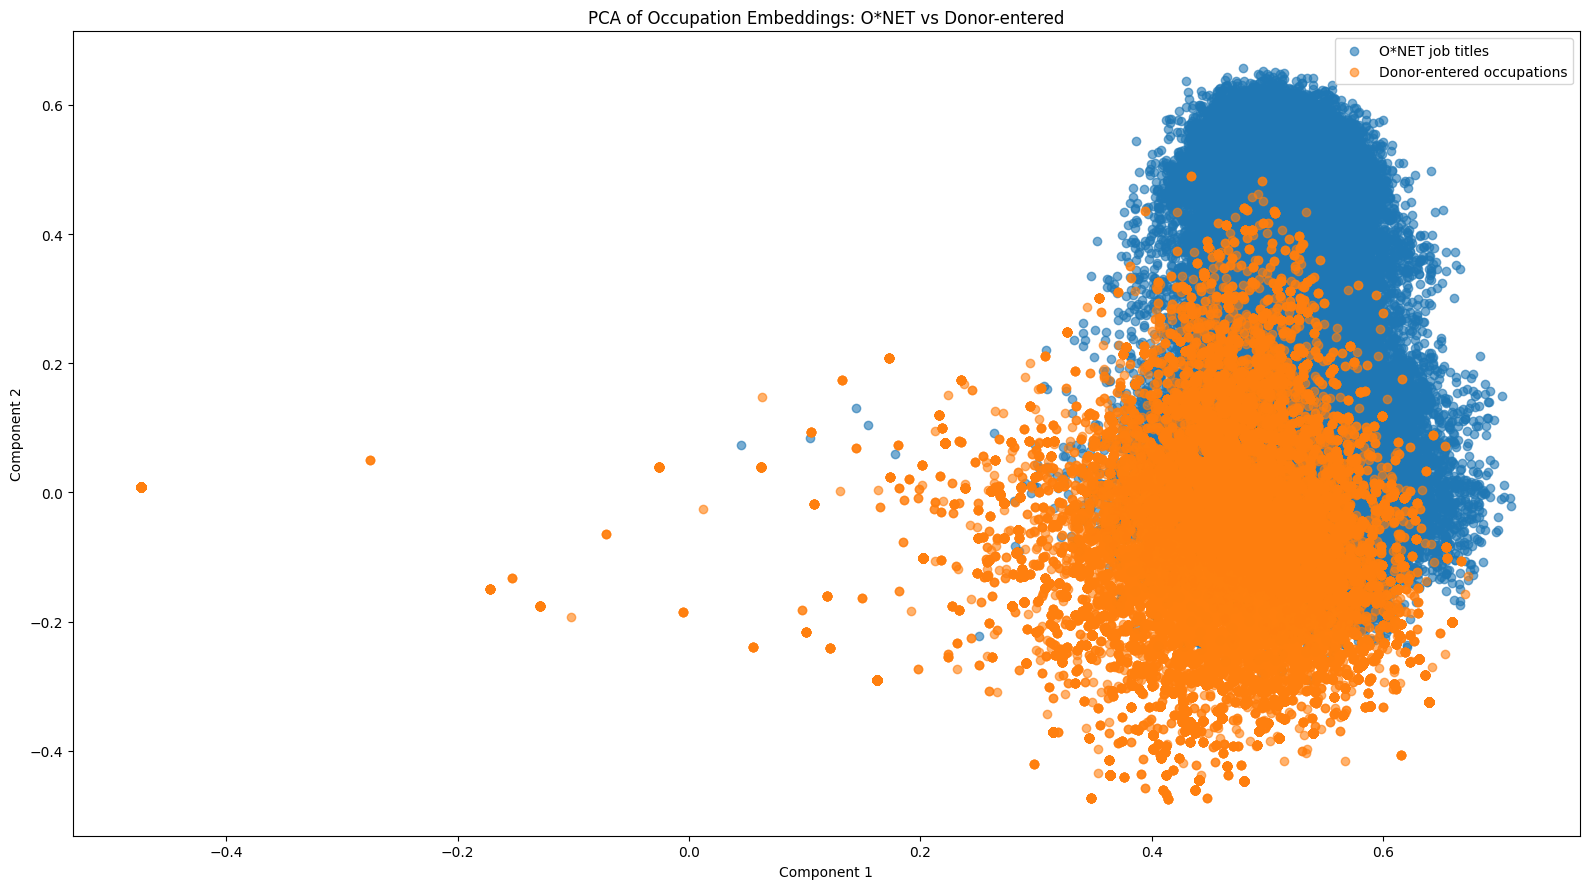

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_onet = np.vstack(onet_df["embedding"].to_numpy())
X_abtx = np.vstack(abtx_df["embedding"].to_numpy())
X_all  = np.vstack([X_onet, X_abtx])

pca = PCA(n_components=2)
proj = pca.fit_transform(X_all)
coords_onet = proj[: len(X_onet)]
coords_abtx = proj[len(X_onet) :]

plt.figure(figsize=(16, 9))
plt.scatter(coords_onet[:, 0], coords_onet[:, 1], alpha=0.6, label="O*NET job titles")
plt.scatter(coords_abtx[:, 0], coords_abtx[:, 1], alpha=0.6, label="Donor-entered occupations")
plt.title("PCA of Occupation Embeddings: O*NET vs Donor-entered")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()
plt.show()

And in our higher-dimension space, we can calculate ad hoc similarities on any arbitrary job title someone might enter:

In [12]:
def normalize(job_title):
  ad_hoc = torch.tensor(
      model.encode(
          [job_title],
          normalize_embeddings=True,
          convert_to_numpy=True,
          show_progress_bar=False,
      ),
      device=device,
  )
  idx = int((ad_hoc @ onet_t.T).argmax(dim=1))
  return f'{job_title} → {onet_df.at[idx, "Title"]}'

print(normalize("code ninja"))
print(normalize("uber"))
print(normalize("GM"))
print(normalize("Professor, Artist"))
print(normalize("Postdoctoral Fellow"))
print(normalize("DARE Officer"))
print(normalize("Senator"))
print(normalize("Comms Director"))
print(normalize("dermatology"))
print(normalize("commodities trader"))
print(normalize("life insurance adjuster"))
print(normalize("lumberjack"))
print(normalize("cpa"))

code ninja → Computer Programmers
uber → Taxi Drivers
GM → General and Operations Managers
Professor, Artist → Art, Drama, and Music Teachers, Postsecondary
Postdoctoral Fellow → Clinical Research Coordinators
DARE Officer → Police and Sheriff's Patrol Officers
Senator → Legislators
Comms Director → Public Relations Managers
dermatology → Dermatologists
commodities trader → Securities, Commodities, and Financial Services Sales Agents
life insurance adjuster → Claims Adjusters, Examiners, and Investigators
lumberjack → Fallers
cpa → Accountants and Auditors


It's not perfect. I don't think I would have normalized **Postdoctoral Fellow** to **Clinical Research Coordinators**. This is where decisions we made in constructing the model start to show themselves. All those ` aka ` job title concatenations we did at the top affected how the language was modeled. Depending on your use case this could be fine; maybe you just need deterministic finite categories. You can play with the embedding calculation process to see how different strategies yield different resules.

As for our nurses:

In [13]:
print(normalize("nurse"))
print(normalize("RN"))
print(normalize("MSN"))
print(normalize("ER Nurse"))
print(normalize("home health nursing"))

nurse → Registered Nurses
RN → Registered Nurses
MSN → Registered Nurses
ER Nurse → Registered Nurses
home health nursing → Registered Nurses


Language models are pretty good at modeling language!